# Score Against NIST Assessors

In [2]:
import collections
import glob 
import json

import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
with open("final-annotated-facts-results.json", "r") as in_file:
    annotation_data = json.load(in_file)

In [3]:
# fact_score = {
#     "USEFUL_FACT": 1.0,
#     "REDUNDANT_FACT": 0.67,
#     "POOR_FACT": 0.33,
#     "LAGGED_FACT": 0.0,
# }

fact_score = {
    "USEFUL_FACT": 1.0,
    "REDUNDANT_FACT": 0.5,
    "POOR_FACT": 0.0,
    "LAGGED_FACT": 0.0,
}


# fact_score = {
#     "USEFUL_FACT": 1.0,
#     "REDUNDANT_FACT": 0.0,
#     "POOR_FACT": 0.0,
#     "LAGGED_FACT": 0.0,
# }

In [4]:
run_scores = []

for req_id,req_data in annotation_data.items():
    print(req_id)
    
    with open("collapsed-event-days/Collapsed-%s.json" % req_id, "r") as in_file:
        collapsed_fact_data = json.load(in_file)
        
    # Generate the scores for each relevant fact the assessor scored
    #. We take the MAXIMUM value associated with a fact for instances
    #. where assessors provided multiple values for a single fact
    fact_df = pd.DataFrame(req_data["fact_list"], columns=["fact_id", "assessor", "label"])
    fact_df["score"] = fact_df["label"].apply(fact_score.get)
    fact_score_df = fact_df[["fact_id", "score"]].groupby("fact_id").max()
    fact_score_map = {idx:row["score"] for idx,row in fact_score_df.iterrows()}
    
    g = nx.Graph()
    for element in collapsed_fact_data:
        collapsed_fact_id = element["collapsed_fact_id"]
        related_facts = element["relevant_facts"]
        
        g.add_node(collapsed_fact_id, vtype="meta", score=fact_score_map.get(collapsed_fact_id,0))
        for sub_fact_id in related_facts:
            g.add_node(sub_fact_id, vtype="raw")
            g.add_edge(sub_fact_id, collapsed_fact_id)
    

    
    # Score this run
    run2facts = [
        (v.replace("%s-" % req_id, "").rpartition("-")[0], v) 
        for v,vd in g.nodes(data=True) if vd["vtype"] != "meta"
    ]

    runsets = {}
    for runtag,fact_id in run2facts:
        this_run_facts = runsets.get(runtag, [])
        this_run_facts.append(fact_id)
        runsets[runtag] = this_run_facts

    nonzero_facts = {v for v,vd in g.nodes(data=True) if vd["vtype"] == "meta" and vd["score"] > 0}
    if len(nonzero_facts) == 0:
        print("CAUTION: No relevant facts in [%s]" % req_id)
        continue
    
    for k,v in runsets.items():

        neighbors = {n_id for f_id in v for n_id in g.neighbors(f_id)}
        local_score = sum([g.nodes[v]["score"] for v in neighbors])
        precision = local_score / len(neighbors)
        recall = len(nonzero_facts.intersection(neighbors)) / len(nonzero_facts)

        run_scores.append((req_id, k, precision, recall))

CrisisFACTS-003-r5
CrisisFACTS-003-r6
CrisisFACTS-003-r7
CrisisFACTS-003-r8
CrisisFACTS-003-r9
CrisisFACTS-003-r10
CrisisFACTS-003-r11
CrisisFACTS-004-r8
CrisisFACTS-004-r9
CrisisFACTS-004-r10
CrisisFACTS-004-r11
CrisisFACTS-004-r12
CrisisFACTS-004-r13
CrisisFACTS-004-r14
CrisisFACTS-004-r15
CrisisFACTS-004-r16
CrisisFACTS-004-r17
CrisisFACTS-004-r18
CrisisFACTS-004-r19
CrisisFACTS-004-r20
CrisisFACTS-004-r21
CrisisFACTS-004-r22
CrisisFACTS-006-r4
CrisisFACTS-006-r5
CrisisFACTS-006-r6
CrisisFACTS-006-r7
CrisisFACTS-007-r13
CrisisFACTS-007-r14
CrisisFACTS-013-r0
CrisisFACTS-013-r1
CrisisFACTS-013-r2
CrisisFACTS-013-r3
CrisisFACTS-013-r4
CrisisFACTS-013-r5
CrisisFACTS-014-r0
CrisisFACTS-014-r1
CrisisFACTS-014-r2
CrisisFACTS-014-r3
CrisisFACTS-014-r4
CrisisFACTS-014-r5
CrisisFACTS-014-r6
CrisisFACTS-001-r3
CrisisFACTS-001-r4
CrisisFACTS-001-r5
CrisisFACTS-001-r6
CrisisFACTS-001-r7
CrisisFACTS-001-r8
CrisisFACTS-001-r9
CrisisFACTS-001-r10
CrisisFACTS-001-r11
CrisisFACTS-011-r0
CrisisFACTS-

In [9]:
score_df = pd.DataFrame(run_scores, columns=["req_id", "run", "redundancy", "comprehensiveness"])

<AxesSubplot:ylabel='req_id'>

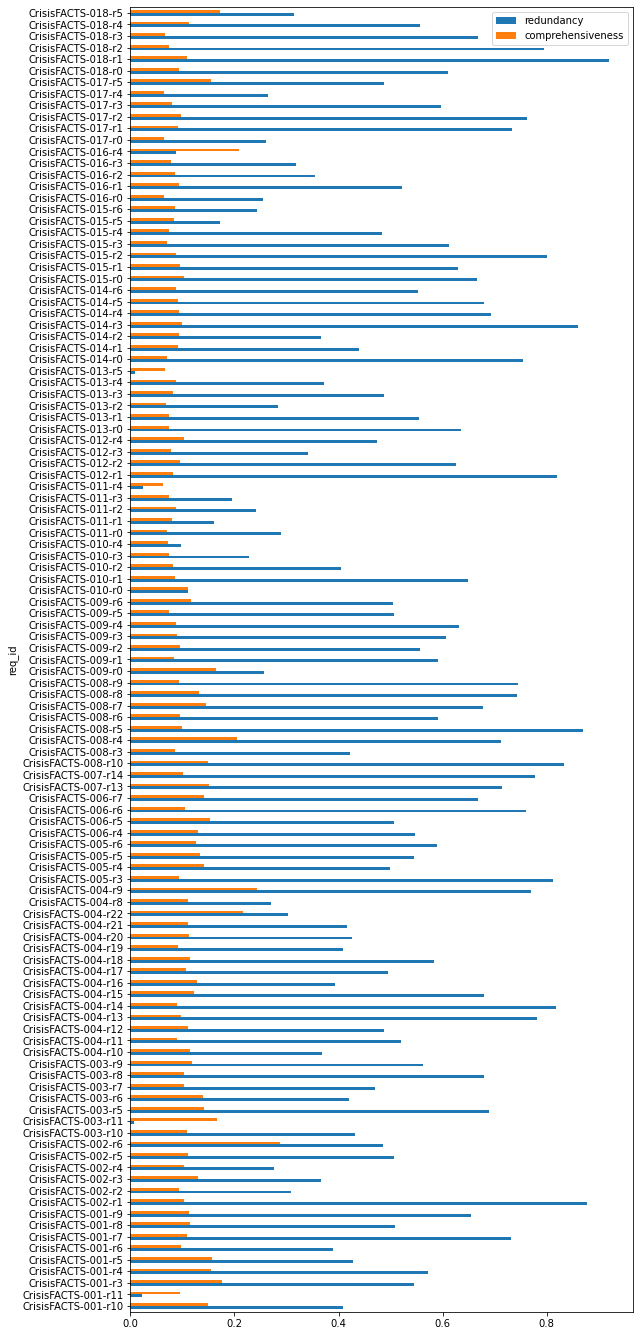

In [10]:
fig = plt.figure(figsize=(9,24))
ax = fig.add_subplot(1,1,1)

score_df[["req_id", "redundancy", "comprehensiveness"]].groupby("req_id").mean().plot.barh(ax=ax)

## Export Run Results

In [3]:
run_metadata_df = pd.read_csv("submissions.csv")

In [ ]:
runtag_map = {idx:row["team"] for idx,row in run_metadata_df.set_index("runtag").iterrows()}
runtag_map

In [ ]:
for run_tag,group in score_df.groupby("run"):
    
    runname = "%s.%s.csv" % (runtag_map[run_tag], run_tag)
    print(run_tag, "-->", runname)
    
    group.to_csv("evaluation.output.assessors/%s" % runname)

In [28]:
score_df["team"] = score_df["run"].apply(runtag_map.get)

In [30]:
score_df.to_csv("evaluation.output.assessors/all_runs.csv")

In [ ]:
score_df = pd.read_csv("evaluation.output.assessors/all_runs.csv", index_col=0)
print(score_df.groupby("req_id").mean().style.to_latex())

In [9]:
print(score_df.groupby("req_id").mean().style.to_latex())

\begin{tabular}{lrr}
 & redundancy & comprehensiveness \\
req_id &  &  \\
CrisisFACTS-001-r10 & 0.408036 & 0.148571 \\
CrisisFACTS-001-r11 & 0.023146 & 0.096154 \\
CrisisFACTS-001-r3 & 0.545749 & 0.175439 \\
CrisisFACTS-001-r4 & 0.572619 & 0.154762 \\
CrisisFACTS-001-r5 & 0.428552 & 0.156682 \\
CrisisFACTS-001-r6 & 0.390097 & 0.096774 \\
CrisisFACTS-001-r7 & 0.731753 & 0.108818 \\
CrisisFACTS-001-r8 & 0.508631 & 0.114219 \\
CrisisFACTS-001-r9 & 0.653487 & 0.113360 \\
CrisisFACTS-002-r1 & 0.877445 & 0.103077 \\
CrisisFACTS-002-r2 & 0.308319 & 0.093301 \\
CrisisFACTS-002-r3 & 0.366703 & 0.129310 \\
CrisisFACTS-002-r4 & 0.276544 & 0.102564 \\
CrisisFACTS-002-r5 & 0.507166 & 0.111663 \\
CrisisFACTS-002-r6 & 0.486058 & 0.287449 \\
CrisisFACTS-003-r10 & 0.432449 & 0.108586 \\
CrisisFACTS-003-r11 & 0.006823 & 0.166667 \\
CrisisFACTS-003-r5 & 0.689328 & 0.141827 \\
CrisisFACTS-003-r6 & 0.420139 & 0.140000 \\
CrisisFACTS-003-r7 & 0.470803 & 0.102564 \\
CrisisFACTS-003-r8 & 0.679622 & 0.102564 \